<a href="https://colab.research.google.com/github/geoncoder/colab-computer-vision/blob/main/Assignment4_Turner_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

cuda:0


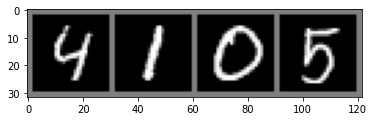

    4     1     0     5
Length of list is 15000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   500] loss: 0.519
[1,  1000] loss: 0.422
[1,  1500] loss: 0.346
[1,  2000] loss: 0.337
[1,  2500] loss: 0.333
[1,  3000] loss: 0.317
[1,  3500] loss: 0.293
[1,  4000] loss: 0.271
[1,  4500] loss: 0.263
[1,  5000] loss: 0.256
[1,  5500] loss: 0.253
[1,  6000] loss: 0.267
[1,  6500] loss: 0.248
[1,  7000] loss: 0.243
[1,  7500] loss: 0.244
[1,  8000] loss: 0.256
[1,  8500] loss: 0.246
[1,  9000] loss: 0.247
[1,  9500] loss: 0.245
[1, 10000] loss: 0.257
[1, 10500] loss: 0.246
[1, 11000] loss: 0.241
[1, 11500] loss: 0.247
[1, 12000] loss: 0.257
[1, 12500] loss: 0.248
[1, 13000] loss: 0.243
[1, 13500] loss: 0.238
[1, 14000] loss: 0.239
[1, 14500] loss: 0.206
[1, 15000] loss: 0.205
[2,   500] loss: 0.194
[2,  1000] loss: 0.196
[2,  1500] loss: 0.190
[2,  2000] loss: 0.128
[2,  2500] loss: 0.143
[2,  3000] loss: 0.138
[2,  3500] loss: 0.137
[2,  4000] loss: 0.139
[2,  4500] loss: 0.134
[2,  5000] loss: 0.128
[2,  5500] loss: 0.131
[2,  6000] loss: 0.136
[2,  6500] loss: 0.128
[2,  7000] 

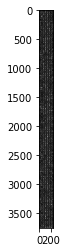

GroundTruth:      7     2     1     0
Predicted:      7     2     1     0
Correct is 9903, Total is 10000
Accuracy of the network on the 10000 test images: 99 %
Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 100 %
Accuracy of     8 : 100 %
Accuracy of     9 : 100 %


In [42]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=0)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return F.log_softmax(x)

net = Net()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))]
)

bs = 4

trainset = torchvision.datasets.MNIST('../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=1)
testset = torchvision.datasets.MNIST('../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000,
                                         shuffle=False, num_workers=1)

classes = ('0', '1', '2', '3', 
           '4', '5', '6', '7', '8', '9')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(bs)))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print("Length of list is %d" % len(trainloader))

#for epoch in range(2):
for epoch in range(10):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data[0].to(device), data[1].to(device)
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 500 == 499:  # print every 500 mini-batches
        print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('Finishing Training')

# Apply the training network to a few test examples

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

images = images.to(device);
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# Apply the trained network to the entire test set
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Correct is %d, Total is %d' % (correct, total))
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# Check the accuracy of each class
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))